In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to c:\users\guezz\appdata\local\temp\pip-req-build-toxzd403
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 'C:\Users\guezz\AppData\Local\Temp\pip-req-build-toxzd403'


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
from tqdm import tqdm

# SARSA($\lambda$) from the book

 We will try to use a Fourier representation instead of tiles coding. This might work out well because the flapping mechanism introduces natural periodicity. When the bird flaps, it ends up at the same vertical position it started, but at a shifted. The environment is bounded to the size of the screen so we already know we will use that screen size as the fundamental period, an.

Given $s = (s_1,s_2)$ the normalized state returned by the package (the horizontal and vertical distance to the next pipe), normalize to be in [0,1]. For $n > 0$ and $i < (n+1)^2$ we define the feature vector with $$x_i = cos(\pi s^T c^i)$$ where 

$$c^i = (i // (n+1) , i  \% (n+1))$$

so that the vectors $c^i$ span the entiere couples of integers between $0$ and $n$. Notice that c^i is actually simply the representation of the number $i$ in basis $n+1$.  

We also define two weight vectors, for the two possible actions : $w_0$ and $w_1$ that are $n+1$-dimensional.  

The Q function is then approximated as $Q(s,a) = \hat Q(x,a) = w_a^T x$. 
The larger $n$ is, the better will be the Fourier approximation of the value function.

Sarsa agent class definition

In [2]:
class SarsaLambdaAgent:
    def __init__(self, env, alpha=0.005, gamma=0.99, epsilon_max=0.1, epsilon_min = 0.01, decay_time = 1000, lambda_=0.9, fourier_order=15):
        self.env = env
        self.infos = []

        self._screen_size = self.env.env.env._screen_size
        self._pipe_gap = self.env.env.env._pipe_gap 

        self.fourier_order = fourier_order
        self.num_features = (fourier_order + 1) ** 2

        # Precompute Fourier basis vectors C^i
        self.C = np.array([[i // (fourier_order + 1), i % (fourier_order + 1)] for i in range(self.num_features)])

        self.alpha = alpha
        self.gamma = gamma
        self.lambda_ = lambda_

        # Epsilon decay parameters
        self.epsilon_start = epsilon_max
        self.epsilon_min = epsilon_min
        self.decay_time = decay_time
        
        # Two weight vectors, one per action.
        # z is the eligibility trace vector.
        self.w = np.random.uniform(-0.1, 0.1, (2, self.num_features))
        self.z = np.zeros((2, self.num_features))

    def state_to_features(self, state):
        x_dist_max = self._screen_size[0] - int(self._screen_size[0] * 0.3)
        x_dist_min = 0
        y_dist_max = self._screen_size[1] - 1 - int(self._pipe_gap // 2)
        y_dist_min = -y_dist_max

        # Normalize to [0, 1]
        s = np.array([
            (state[0] - x_dist_min) / (x_dist_max - x_dist_min),
            (state[1] - y_dist_min) / (y_dist_max - y_dist_min)
        ])

        features =  np.cos(np.pi * self.C @ s)
        return np.clip(features, -1, 1)

    def compute_epsilon(self):
        return self.epsilon_min + (self.epsilon_start - self.epsilon_min) * np.exp(-self.episode/self.decay_time)


    def choose_action(self, features):
        # Epsilon-greedy action selection. Espilon slowly decays to 
        if np.random.rand() < self.epsilon:          
            return np.random.randint(2)  # Random action
        
        q_values = [np.dot(self.w[a], features) for a in range(2)]
        return np.argmax(q_values)

    def train_episode(self):
        errors = []
        self.z.fill(0.0)  # Reset eligibility traces
        state, info = self.env.reset()

        features = self.state_to_features(state)
        action = np.random.randint(2)  # Randomly choose action for the first step

        done = False
        total_reward = 0

        while not done:
            next_state, reward, done, _, info = self.env.step(action)
            next_features = self.state_to_features(next_state)
            next_action = self.choose_action(next_features)

            if done:
                q_next = 0
            else:
                q_next = np.dot(self.w[next_action], next_features)
            # TD error
            q_current = np.dot(self.w[action], features)
            delta = reward + self.gamma * q_next - q_current
            errors.append(abs(delta)**2)

            # Update eligibility traces
            self.z *= self.gamma * self.lambda_
            self.z[action] += features  # Accumulate trace for current action

            # Weight update
            self.w += self.alpha * delta * self.z

            # Move to next step
            state = next_state
            features = next_features
            action = next_action
            total_reward += reward

        return info, sum(errors)/len(errors)
    
    def train(self, num_episodes):
        self.episode = 0
        self.epsilon = self.epsilon_start
        td_errors = []
        scores = []
        for episode in tqdm(range(num_episodes)):
            self.episode +=1
            if episode % self.decay_time == 0:
                self.epsilon = self.compute_epsilon()
            _  = self.env.reset()
            info, error = self.train_episode()

            scores.append(info['score'])
            td_errors.append(error)

        return np.array(scores), np.array(td_errors)

Training, and collecting results

In [3]:
env = gym.make('TextFlappyBird-v0')
_ = env.reset()
agent = SarsaLambdaAgent(env, alpha=0.005, gamma=0.99, epsilon_max=0.1, epsilon_min= 0.01, decay_time= 1000, lambda_=0.1, fourier_order=15)

In [4]:
scores_simple, errors_simple = agent.train(10**4)

100%|██████████| 10000/10000 [01:06<00:00, 150.31it/s]


Support functions to graph results and make figures for the report

In [10]:
def plot_training_results(td_errors, scores, avg_window=500):
    episodes = np.arange(len(scores))

    def moving_average(x, w):
        return np.convolve(x, np.ones(w)/w, mode='valid')

    def get_margin_limits(smoothed):
        min_val, max_val = np.min(smoothed), np.max(smoothed)
        margin = 0.15 * (max_val - min_val)
        return min_val - margin, max_val + margin

    # Smoothed data
    avg_scores = moving_average(scores, avg_window)
    avg_td_errors = moving_average(td_errors, avg_window)

    avg_episodes = np.arange(avg_window - 1, len(scores))

    # Y-axis limits with margins
    score_ylim = get_margin_limits(avg_scores)
    td_error_ylim = get_margin_limits(avg_td_errors)

    fig, axs = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

    # Score
    axs[0].plot(episodes, scores, alpha=0.3, label='Score')
    axs[0].plot(avg_episodes, avg_scores, label=f'Score (avg {avg_window})', linewidth=2)
    axs[0].set_ylabel("Score")
    axs[0].set_ylim(score_ylim)
    axs[0].grid(True, linestyle='--', alpha=0.5)
    axs[0].legend()

    # TD Errors
    axs[1].plot(episodes, td_errors, alpha=0.3, label='TD Errors')
    axs[1].plot(avg_episodes, avg_td_errors, label=f'TD Errors (avg {avg_window})', linewidth=2)
    axs[1].set_ylabel("TD Errors")
    axs[1].set_ylim(td_error_ylim)
    axs[1].grid(True, linestyle='--', alpha=0.5)
    axs[1].legend()

    # plt.suptitle("SARSA(lambda) Agent Training Metrics", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

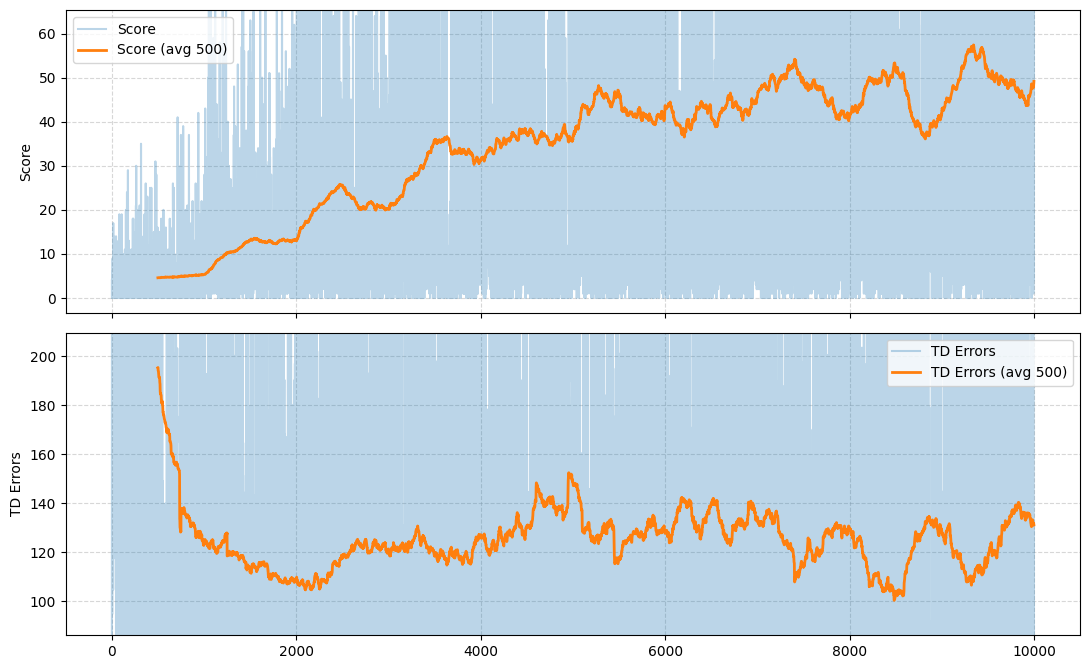

In [12]:
plot_training_results(errors_simple, scores_simple, avg_window=500)

In [18]:
def plot_q_function(agent, grid_size=50):
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    xx, yy = np.meshgrid(x, y)
    
    q_values = {0: np.zeros_like(xx), 1: np.zeros_like(xx)}
    
    for i in range(grid_size):
        for j in range(grid_size):
            s = np.array([xx[i, j], yy[i, j]])
            features = np.cos(np.pi * agent.C @ s)
            features = np.clip(features, -1, 1)
            for a in [0, 1]:
                q_values[a][i, j] = np.dot(agent.w[a], features)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
    im = None
    for a in [0, 1]:
        im = axs[a].imshow(
            q_values[a],
            origin='lower',
            extent=[0, 1, 0, 1],
            aspect='auto',
            cmap='viridis',
            vmin=min(np.min(q_values[0]), np.min(q_values[1])),
            vmax=max(np.max(q_values[0]), np.max(q_values[1]))
        )
        axs[a].set_title(f"Q(s, a={a})", fontsize=12)
        axs[a].set_xlabel("x (normalized)")
        axs[a].set_ylabel("y (normalized)")
    
    # Add a single shared colorbar on the right
    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.8, orientation='vertical')
    cbar.set_label("Q-value", fontsize=11)

    # plt.suptitle("Learned Q-function Heatmaps", fontsize=14)
    plt.show()

In [ ]:
plot_q_function(agent)

### Hyperparameters optimization

In [13]:
def evaluate_agent(episodes=5000, **kwargs):
    """
    Potential kwargs:
    alpha, lambda_, fourier_order, epsilon_max, epsilon_min
    """
    env = gym.make('TextFlappyBird-v0')
    _ = env.reset()
    agent = SarsaLambdaAgent(env, **kwargs)
    scores, _ = agent.train(episodes)
    #evaluation = avg score on last n episodes
    return scores

Let's start with tweaking the lambda

In [17]:
lambdas = np.linspace(0, 1, 10)
lambdas_evaluations = []
for lam in tqdm(lambdas , ):
    score = evaluate_agent(lambda_ = lam)
    lambdas_evaluations.append((lam, score))

100%|██████████| 10/10 [03:05<00:00, 18.51s/it]


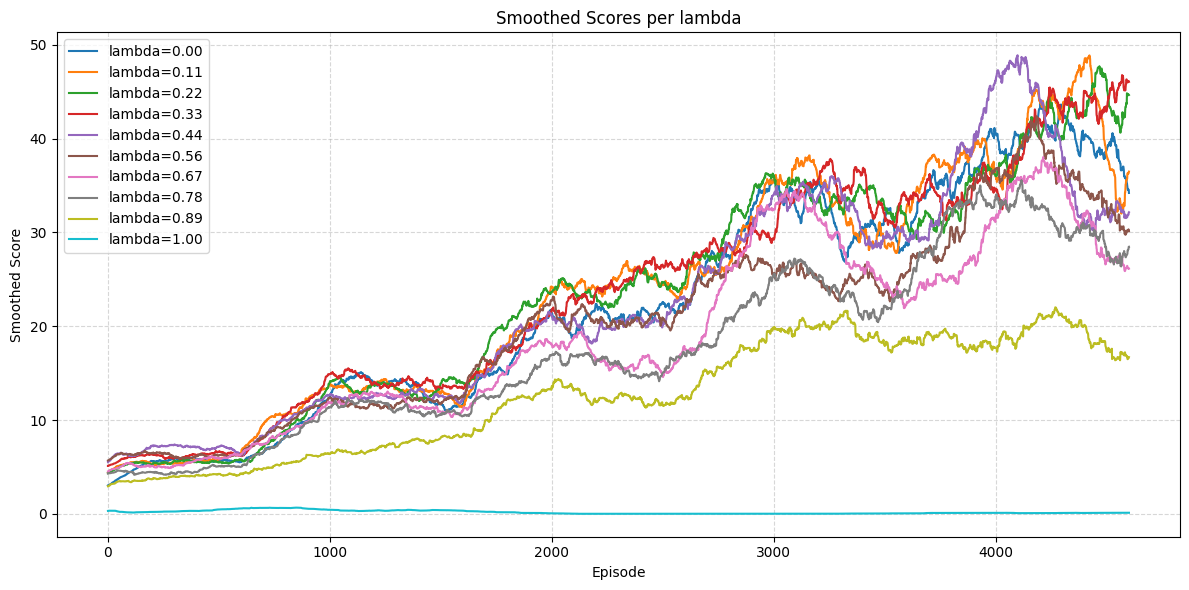

In [ ]:
def moving_average(x, w=400):
    return np.convolve(x, np.ones(w) / w, mode='valid')

plt.figure(figsize=(12, 6))

for lam, scores in lambdas_evaluations:
    smoothed = moving_average(scores)
    episodes = np.arange(len(smoothed))
    plt.plot(episodes, smoothed, label=f"lambda={lam:.2f}")

plt.title("Smoothed Scores per lambda")
plt.xlabel("Episode")
plt.ylabel("Smoothed Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Now let's generalize and try to optimize other parameters. We're using parralelized processing to speed up the process

In [ ]:
from sklearn.model_selection import ParameterSampler
from concurrent.futures import ProcessPoolExecutor, as_completed

last_n = 750

# Define the parameter grid
param_grid = {
    "alpha": np.logspace(-4, -1.5, 10),
    "lambda_": np.linspace(0.1, 1, 10),
    "fourier_order": [5, 7, 10, 15, 20],
    "epsilon_min": np.linspace(0.001, 0.05, 5),
}

# Generate random combinations of parameters
n_iter = 500
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

# Evaluation wrapper for multiprocessing
def evaluate_params(params):
    scores = evaluate_agent(episodes=5000, **params)
    return (params, np.array(scores))

# Parallel evaluation using ProcessPoolExecutor
results = []
with ProcessPoolExecutor() as executor:
    # Submit all tasks
    futures = {executor.submit(evaluate_params, params): params for params in param_list}
    
    # As they complete, collect results with tqdm progress bar
    for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating"):
        results.append(future.result())

# Sort results by average score on last_n episodes
results.sort(key=lambda x: x[1][last_n:].mean(), reverse=True)

  3%|▎         | 169/5000 [00:00<00:02, 1680.56it/s]/tmp/ipykernel_3916153/1687147356.py:79: RuntimeWarning: overflow encountered in scalar power
  errors.append(abs(delta)**2)
  1%|          | 47/5000 [00:00<00:10, 467.29it/s]/tmp/ipykernel_3916153/1687147356.py:94: RuntimeWarning: overflow encountered in scalar add
  return info, sum(errors)/len(errors)
 22%|██▏       | 1105/5000 [00:00<00:01, 2738.73it/s]/tmp/ipykernel_3916153/1687147356.py:94: RuntimeWarning: overflow encountered in scalar add
  return info, sum(errors)/len(errors)
 10%|█         | 514/5000 [00:00<00:02, 1613.95it/s]/tmp/ipykernel_3916153/1687147356.py:79: RuntimeWarning: overflow encountered in scalar power
  errors.append(abs(delta)**2)
 15%|█▍        | 738/5000 [00:00<00:02, 1854.46it/s]/tmp/ipykernel_3916153/1687147356.py:79: RuntimeWarning: overflow encountered in scalar power
  errors.append(abs(delta)**2)
 18%|█▊        | 885/5000 [00:01<00:09, 451.06it/s]]]/tmp/ipykernel_3916153/1687147356.py:79: RuntimeWar

Top 10 parameter combinations:


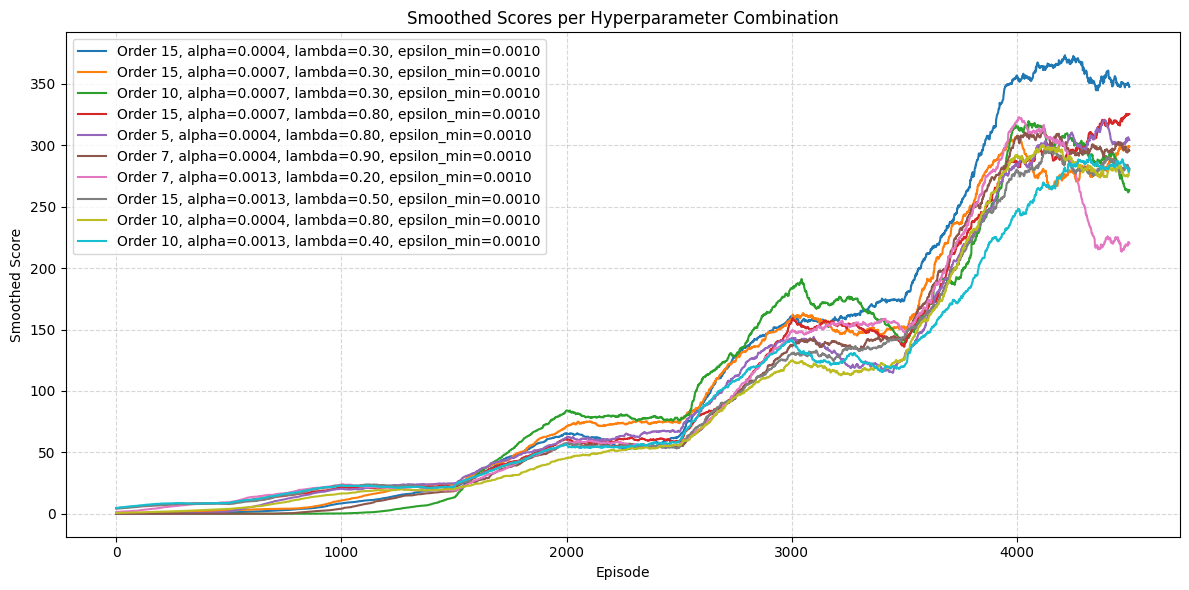

In [ ]:
# Print the top 10 parameter combinations
print("Top 10 parameter combinations:")

plt.figure(figsize=(12, 6))


for i, (params, score) in enumerate(results[:10]):
    smoothed = moving_average(score)
    episodes = np.arange(len(smoothed))
    plt.plot(episodes, smoothed, label=f"Order {params['fourier_order']}, alpha={params['alpha']:.4f}, lambda={params['lambda_']:.2f}, epsilon_min={params['epsilon_min']:.4f}")

plt.title("Smoothed Scores per Hyperparameter Combination")
plt.xlabel("Episode")
plt.ylabel("Smoothed Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

#### Let's see how to agent does with a different window size

In [23]:
agent._screen_size

(20, 15)

In [ ]:
agent._screen_size
env2sarsa = gym.make('TextFlappyBird-v0', width=25, height=30, pipe_gap=8)
_ = env2sarsa.reset()
agent2 = SarsaLambdaAgent(env2sarsa, alpha=0, gamma=0.99, epsilon_max=0.005, epsilon_min= 0.001, decay_time= 1000, lambda_=0.1, fourier_order=15)

agent2.w = agent.w.copy() #Tranfer the learned weights
scores_simple2, errors_simple2 = agent2.train(1000) #Let's just see how it does for 1000 episodes

100%|██████████| 1000/1000 [00:13<00:00, 73.63it/s]


In [26]:
agent._screen_size
env3sarsa = gym.make('TextFlappyBird-v0', width=10, height=15, pipe_gap=4)
_ = env2sarsa.reset()
agent3 = SarsaLambdaAgent(env3sarsa, alpha=0, gamma=0.99, epsilon_max=0.005, epsilon_min= 0.001, decay_time= 1000, lambda_=0.1, fourier_order=15)

agent3.w = agent.w.copy() #Tranfer the learned weights
scores_simple3, errors_simple3 = agent3.train(1000) #Let's just see how it does for 1000 episodes

100%|██████████| 1000/1000 [00:00<00:00, 4704.57it/s]


In [30]:
print("Average score for the environment 2: ", scores_simple2[:100].mean())
print("Average score for the environment 3: ", scores_simple3[:100].mean())

Average score for the environment 2:  60.55
Average score for the environment 3:  0.55


In [7]:
def plot_score_results(scores, avg_window=500):
    episodes = np.arange(len(scores))

    def moving_average(x, w):
        return np.convolve(x, np.ones(w)/w, mode='valid')

    def get_margin_limits(smoothed):
        min_val, max_val = np.min(smoothed), np.max(smoothed)
        margin = 0.15 * (max_val - min_val)
        return min_val - margin, max_val + margin

    # Smoothed data
    avg_scores = moving_average(scores, avg_window)
    avg_episodes = np.arange(avg_window - 1, len(scores))

    # Y-axis limits with margins
    score_ylim = get_margin_limits(avg_scores)

    plt.figure(figsize=(10, 5))
    plt.plot(episodes, scores, alpha=0.3, label='Score')
    plt.plot(avg_episodes, avg_scores, label=f'Score (avg {avg_window})', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episodes")
    plt.ylim(score_ylim)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.title("Training Progress")
    plt.tight_layout()
    plt.show()

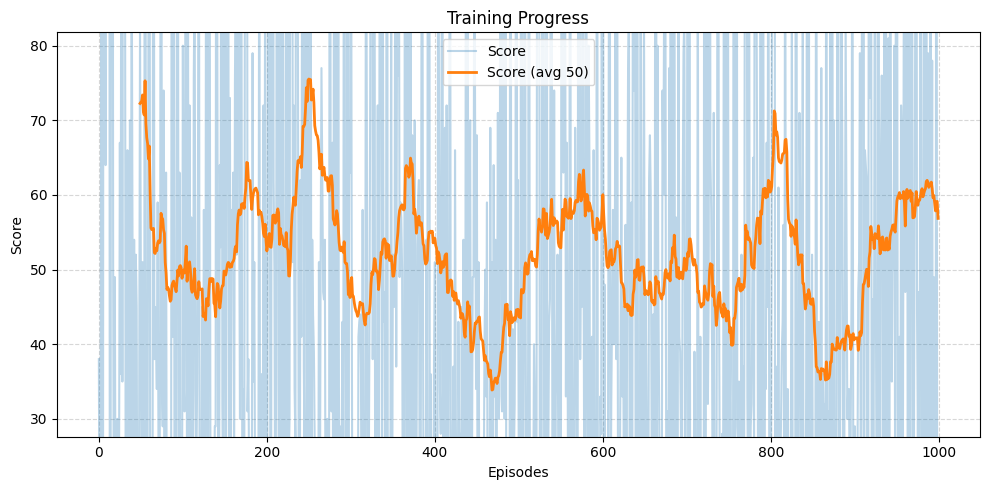

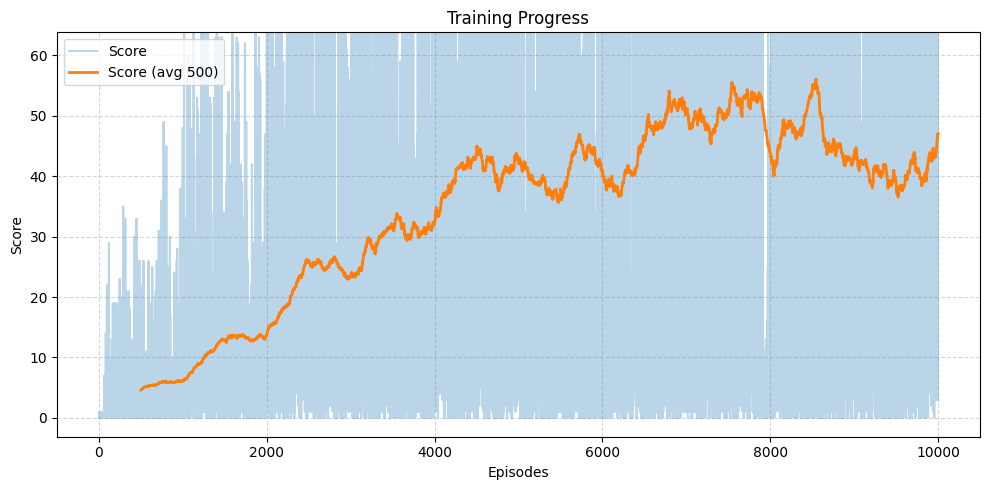

In [22]:
plot_score_results(scores_simple2, avg_window=50)
plot_score_results(scores_simple, avg_window=500)

## Monte-Carlo approach

Of course the architechture of the class is recycled from SARSA

In [14]:
class MonteCarloAgent:
    def __init__(self, env, alpha=0.005, gamma=0.99, epsilon_max=0.1, 
                 epsilon_min=0.01, decay_time=1000, fourier_order=15):
        self.env = env
        self.infos = []

        self._screen_size = self.env.env.env._screen_size
        self._pipe_gap = self.env.env.env._pipe_gap 

        self.fourier_order = fourier_order
        self.num_features = (fourier_order + 1) ** 2

        # Precompute Fourier basis vectors C^i
        self.C = np.array([[i // (fourier_order + 1), i % (fourier_order + 1)] 
                             for i in range(self.num_features)])

        self.alpha = alpha
        self.gamma = gamma

        # Epsilon decay parameters
        self.epsilon_start = epsilon_max
        self.epsilon_min = epsilon_min
        self.decay_time = decay_time
        
        # Two weight vectors, one per action.
        self.w = np.random.uniform(-0.1, 0.1, (2, self.num_features))
        
    def state_to_features(self, state):
        # like sarsa
        x_dist_max = self._screen_size[0] - int(self._screen_size[0] * 0.3)
        x_dist_min = 0
        y_dist_max = self._screen_size[1] - 1 - int(self._pipe_gap // 2)
        y_dist_min = -y_dist_max

        # Normalize to [0, 1]
        s = np.array([
            (state[0] - x_dist_min) / (x_dist_max - x_dist_min),
            (state[1] - y_dist_min) / (y_dist_max - y_dist_min)
        ])

        features = np.cos(np.pi * self.C @ s)
        return np.clip(features, -1, 1)
    
    def compute_epsilon(self):
        # like sarsa
        return self.epsilon_min + (self.epsilon_start - self.epsilon_min) * np.exp(-self.episode/self.decay_time)
    
    def choose_action(self, features):
        # like sarsa
        # Epsilon-greedy selection
        if np.random.rand() < self.epsilon:
            return np.random.randint(2)
        q_values = [np.dot(self.w[a], features) for a in range(2)]
        return np.argmax(q_values)
    
    def generate_episode(self):
        """
        Generates a complete episode and collects transitions.
        Each transition is a tuple: (features, action, reward)
        """
        episode_transitions = []
        state, info = self.env.reset()
        features = self.state_to_features(state)
        action = np.random.randint(2)  # Randomly choose action for the first step
        done = False
        total_reward = 0
        
        while not done:
            next_state, reward, done, _, info = self.env.step(action)
            next_features = self.state_to_features(next_state)
            
            # Store the transition
            episode_transitions.append((features, action, reward))
            total_reward += reward
            
            features = next_features
            if not done:
                action = self.choose_action(features)
        return info, episode_transitions, total_reward
    
    def train_episode(self):
        """
        See page 123 of the RL book. Modified so that instead of computing the average(Returns(S,A)) it does simply a linear update with coefficent alpha, as seen in the course. Also, it's an every-visit MC update instead of first-visit.

        Runs one episode, then performs every-visit Monte Carlo updates.
        Returns info, the average squared Monte Carlo error in the episode, and total reward.
        """
        info, episode_transitions, total_reward = self.generate_episode()
        T = len(episode_transitions)
        returns = np.zeros(T)
        G = 0
        # Compute the return G_t backwards
        for t in reversed(range(T)):
            _, _, reward = episode_transitions[t]
            G = reward + self.gamma * G
            returns[t] = G
        
        # Update weight vectors for every transition
        squared_errors = []
        for t in range(T):
            features, action, _ = episode_transitions[t]
            q_val = np.dot(self.w[action], features)
            error = returns[t] - q_val
            squared_errors.append(error**2)
            # Monte Carlo update (every-visit)
            self.w[action] += self.alpha * error * features
        
        avg_error = np.mean(squared_errors) if T > 0 else 0
        return info, avg_error, total_reward
    
    def train(self, num_episodes):
        self.episode = 0
        self.epsilon = self.epsilon_start
        td_errors = []   # Average Monte Carlo squared errors per episode
        scores = []
        for episode in tqdm(range(num_episodes)):
            self.episode += 1
            if episode % self.decay_time == 0:
                self.epsilon = self.compute_epsilon()
            _ = self.env.reset()
            info, error, total_reward = self.train_episode()
            scores.append(info['score'])
            td_errors.append(error)
        return np.array(scores), np.array(td_errors)


Now let's train it

In [15]:
envmc = gym.make('TextFlappyBird-v0')
_ = envmc.reset()
agentmc = MonteCarloAgent(envmc, alpha=0.005, gamma=0.99, epsilon_max=0.1, epsilon_min= 0.01, decay_time= 1000, fourier_order=15)
scores_mc, errors_mc = agentmc.train(10**4)

100%|██████████| 10000/10000 [00:16<00:00, 595.22it/s]


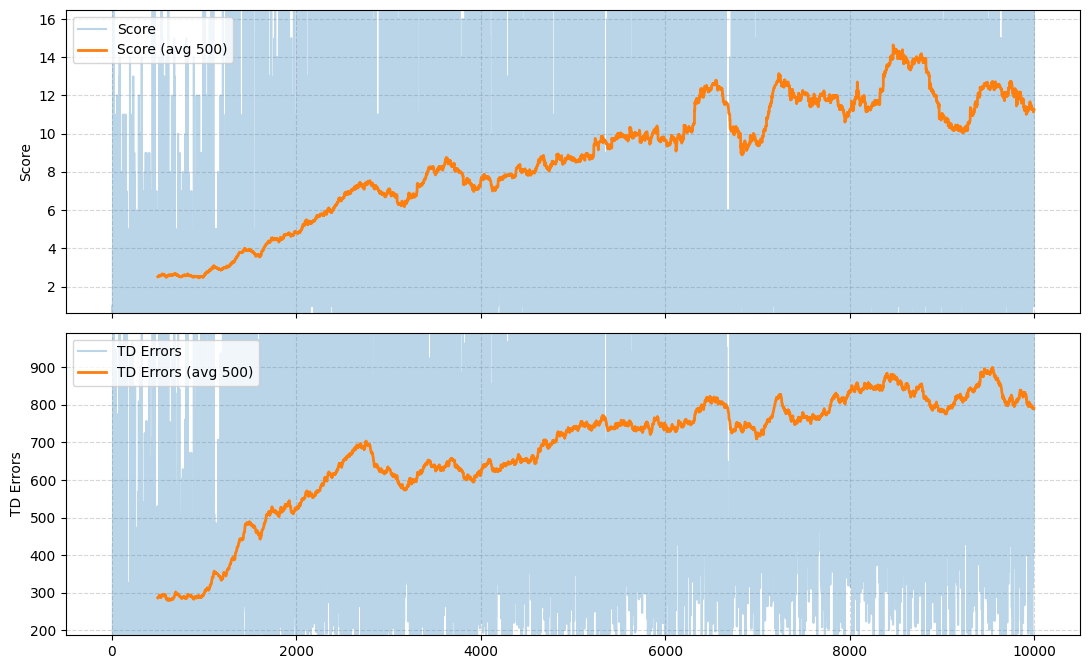

In [16]:
plot_training_results(errors_mc, scores_mc, avg_window=500)

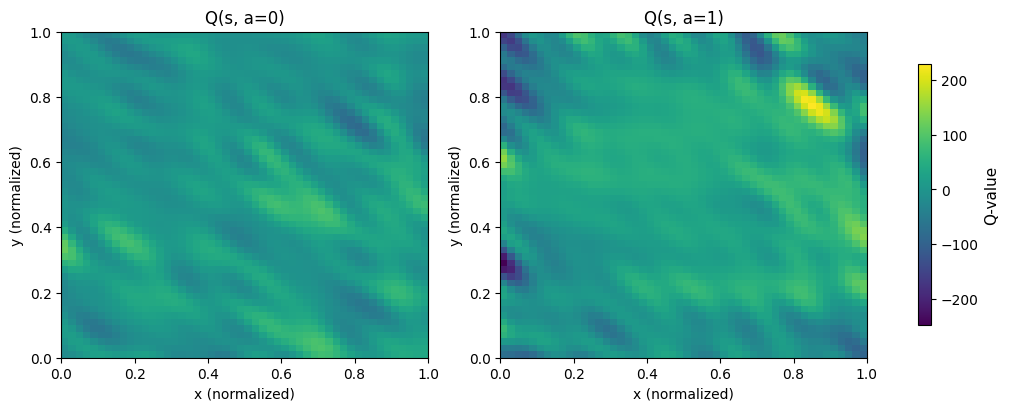

In [19]:
plot_q_function(agentmc)

In [18]:
def evaluate_mc_agent(episodes=5000, **kwargs):
    """
    Potential kwargs:
    alpha, lambda_, fourier_order, epsilon_max, epsilon_min
    """
    env = gym.make('TextFlappyBird-v0')
    _ = env.reset()
    agent = MonteCarloAgent(env, **kwargs)
    scores, _ = agent.train(episodes)
    #evaluation = avg score on last n episodes
    return scores

In [ ]:
from sklearn.model_selection import ParameterSampler
from concurrent.futures import ProcessPoolExecutor, as_completed

last_n = 1000

# Define the parameter grid
param_grid = {
    "alpha": np.logspace(-4, -1.5, 10),
    "fourier_order": [5, 7, 10, 15, 20],
    "epsilon_min": np.linspace(0.001, 0.05, 5),
}

# Generate random combinations of parameters
n_iter = 200
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

# Evaluation wrapper for multiprocessing
def evaluate_params(params):
    scores = evaluate_mc_agent(episodes=5000, **params)
    return (params, np.array(scores))

# Parallel evaluation using ProcessPoolExecutor
results = []
with ProcessPoolExecutor() as executor:
    # Submit all tasks
    futures = {executor.submit(evaluate_params, params): params for params in param_list}
    
    # As they complete, collect results with tqdm progress bar
    for future in tqdm(as_completed(futures), total=len(futures), desc="Evaluating"):
        results.append(future.result())

# Sort results by average score on last_n episodes
results.sort(key=lambda x: x[1][last_n:].mean(), reverse=True)

 36%|███▌      | 1779/5000 [00:01<00:03, 957.04it/s]]/tmp/ipykernel_98218/4234474231.py:104: RuntimeWarning: overflow encountered in scalar power
  squared_errors.append(error**2)
100%|██████████| 5000/5000 [00:01<00:00, 2536.55it/s]/home/guezzir/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)

 28%|██▊       | 1414/5000 [00:02<00:05, 640.27it/s]]7s/it]/home/guezzir/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
 57%|█████▋    | 2849/5000 [00:02<00:01, 1420.32it/s]/tmp/ipykernel_98218/4234474231.py:104: RuntimeWarning: overflow encountered in scalar power
  squared_errors.append(error**2)
 50%|████▉     | 2488/5000 [00:03<00:04, 619.50it/s]]/home/guezzir/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: ove

Top 10 parameter combinations:


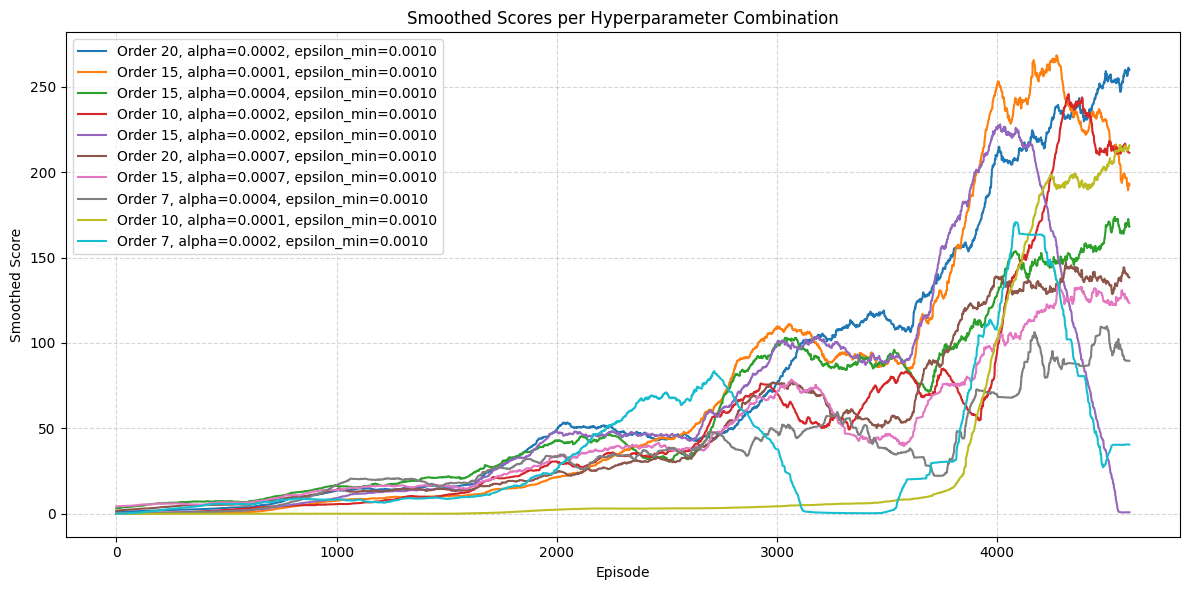

In [22]:
# Print the top 10 parameter combinations
print("Top 10 parameter combinations:")

plt.figure(figsize=(12, 6))


for i, (params, score) in enumerate(results[:10]):
    smoothed = moving_average(score)
    episodes = np.arange(len(smoothed))
    plt.plot(episodes, smoothed, label=f"Order {params['fourier_order']}, alpha={params['alpha']:.4f}, epsilon_min={params['epsilon_min']:.4f}")

plt.title("Smoothed Scores per Hyperparameter Combination")
plt.xlabel("Episode")
plt.ylabel("Smoothed Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()